<a href="https://colab.research.google.com/github/Jhatton2/MapReduce/blob/main/Mod6_MapReduce_jhatton2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Reduce with Spark - Individual Assignment.

### The code below uses map reduce in spark in order to provide a word count. Your task is to copy and modify the code in order to generate a similar analysis on a book of your choice.

 * Start by picking a book and finding its txt file https://www.gutenberg.org/
 * Ensure the starter code works. This starter code finds and lists the _most frequent single words_ that appear in the book.
 * Create three different map reduce operations that:
 * (1) One task that finds and lists the _longest single words_ used in the book. For example, the word "three" would have a length of "5".
 * (2) Another task that finds and lists the _most frequent bigrams_. A bigram is a pair of words that appear next to each other. For example, the phrase "one two three four" will have the bigrams "one two" "two three" and "three four".
 * (3) Another task that finds and lists a _customized statistic_. Pick any other kind of text counting statistic that you want to use map reduce for. Explain it and then implement it in this notebook.

In [ ]:
from pyspark.context import SparkContext
from pyspark.conf import SparkConf
import urllib.request
import re
import pandas as pd

# Stop any existing SparkContext
try:
    sc.stop()
except:
    pass

# Create a SparkConf
conf = SparkConf().setAppName("WordAnalysis").setMaster("local").set("spark.driver.allowMultipleContexts", "true")

# Create a SparkContext
sc = SparkContext(conf=conf)

# Fetch and read the text from a URL
url = "https://www.gutenberg.org/cache/epub/61596/pg61596.txt"
response = urllib.request.urlopen(url)
text = response.read().decode('utf-8')


# Helper functions
def split_line(line):
    # Split each line into words
    return line.split()

def map_word_to_one(word):
    # Map each word to a (word, 1) pair
    return (word, 1)

def add_counts(a, b):
    # Reduce function to sum counts
    return a + b


# Remove header and footer based on keywords typical in Project Gutenberg texts
start_idx = text.find("*** START OF THE PROJECT GUTENBERG EBOOK THE AENEID OF VIRGIL")
end_idx = text.find("*** END OF THE PROJECT GUTENBERG EBOOK THE AENEID OF VIRGIL")
text = text[start_idx:end_idx] if start_idx != -1 and end_idx != -1 else text


# Clean the text: Convert to lowercase and remove non-alphabetic characters
cleaned_text = re.sub(r'[^a-z\s]', '', text.lower())

# Convert to lowercase, remove newlines, and remove non-alphabetic characters while preserving spaces and hyphens
cleaned_text = re.sub(r'\n+', ' ', text.lower())  # Replace newlines with a space

# Replace hyphens with a space
cleaned_text = re.sub(r'-+', ' ', cleaned_text)

# Further clean to keep only alphabetic characters, spaces, and hyphens (and optional accented characters)
cleaned_text = re.sub(r'[^a-záéíóúüñ\s-]', '', cleaned_text)

# Remove extra whitespace (including multiple spaces)
cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()



# Split into lines for the RDD
text_lines = cleaned_text.splitlines()

# Create an RDD from the list of lines
text_file = sc.parallelize(text_lines)



# Define a list of stop words
stop_words = set([
    "the","i", "and", "a", "an", "is", "it", "of", "to", "in", "that", "with", "as", "for", "on",
    "was", "were", "by", "at", "which", "be", "this", "from", "or", "are", "but", "not",
    "they", "their", "can", "have", "has", "had", "if", "you", "we", "he", "she", "his",
    "her", "will", "would", "there", "been", "one", "all", "about", "them", "more", "when",
    "so", "no", "who", "what", "me", "do", "just", "like", "now", "my", "your", "than",
    "then", "out", "some", "into", "up", "could", "time", "man","www", "gutenberg", "org", "copyright",
    "contact", "license", "donate", "wwwgutenbergorglicense","wwwgutenbergorgcontact", "wwwgutenbergorgdonate",
    "wwwgutenbergorgdonate", "wwwgutenbergorg", "trademarkcopyright"
])

# Filter function to exclude unwanted patterns and stop words
def filter_word(word):
    #unwanted_patterns = ["www", "gutenberg", "org", "copyright", "contact", "license", "donate"]
    return word not in stop_words


# Task 1: Find the longest single words
def find_longest_words(rdd, num_words=10):
    # Find the longest word by flattening, filtering, and mapping to (word, length) in a single line
    word_lengths = rdd.flatMap(split_line).filter(filter_word).map(lambda word: (word, len(word)))
    longest_words = word_lengths.filter(filter_word).takeOrdered(num_words, key=lambda x: -x[1])
    return longest_words

# Task 2: Count word frequency
word_counts = text_file.flatMap(split_line).filter(filter_word).map(map_word_to_one).reduceByKey(add_counts)
word_counts_sorted = word_counts.sortBy(lambda x: x[1], ascending=False)

# Collect the top N words and their counts
top_n = 50  # Adjust this as needed
top_n_words = word_counts_sorted.take(top_n)

# Create a Pandas DataFrame from the top N words
top_n_df = pd.DataFrame(top_n_words, columns=['word', 'count'])

# Execution for Task 1
longest_words = find_longest_words(text_file, num_words=10)

# Display results
print("Longest Words:")
for word, length in longest_words:
    print(f"{word}: {length}")

# Display the top N frequent words as a DataFrame
print("\nTop N Words by Frequency:")
print(top_n_df)



Longest Words:
invulnerability: 15
dissatisfaction: 15
unsatisfactory: 14
vindictiveness: 14
constellations: 14
accomplishment: 14
acknowledgment: 14
constellations: 14
unsuccessfully: 14
impressionable: 14

Top N Words by Frequency:
       word  count
0       him    501
1    aeneas    329
2      over    323
3       our    239
4   through    236
5      down    235
6       men    222
7      came    214
8     great    206
9    turnus    204
10     here    203
11      son    200
12       us    186
13      let    180
14     gods    168
15    where    161
16  trojans    161
17   father    158
18     city    155
19     come    149
20     arms    142
21      war    140
22   heaven    137
23      off    131
24     fire    129
25     back    122
26    under    119
27     made    119
28      way    115
29        o    115
30   trojan    113
31     troy    112
32     left    111
33     king    111
34    first    109
35    these    109
36    walls    108
37   battle    104
38      see    104
39    

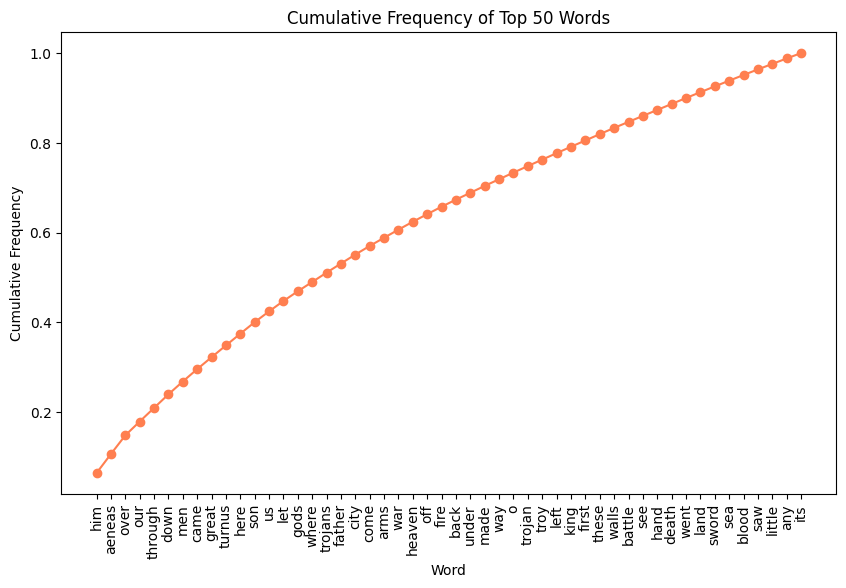

In [ ]:
plt.figure(figsize=(10, 6))
cumulative_freq = top_n_df['count'].cumsum() / top_n_df['count'].sum()
plt.plot(cumulative_freq, marker='o', color='coral')
plt.xticks(range(len(top_n_df)), top_n_df['word'], rotation=90)
plt.xlabel('Word')
plt.ylabel('Cumulative Frequency')
plt.title(f'Cumulative Frequency of Top {top_n} Words')
plt.show()


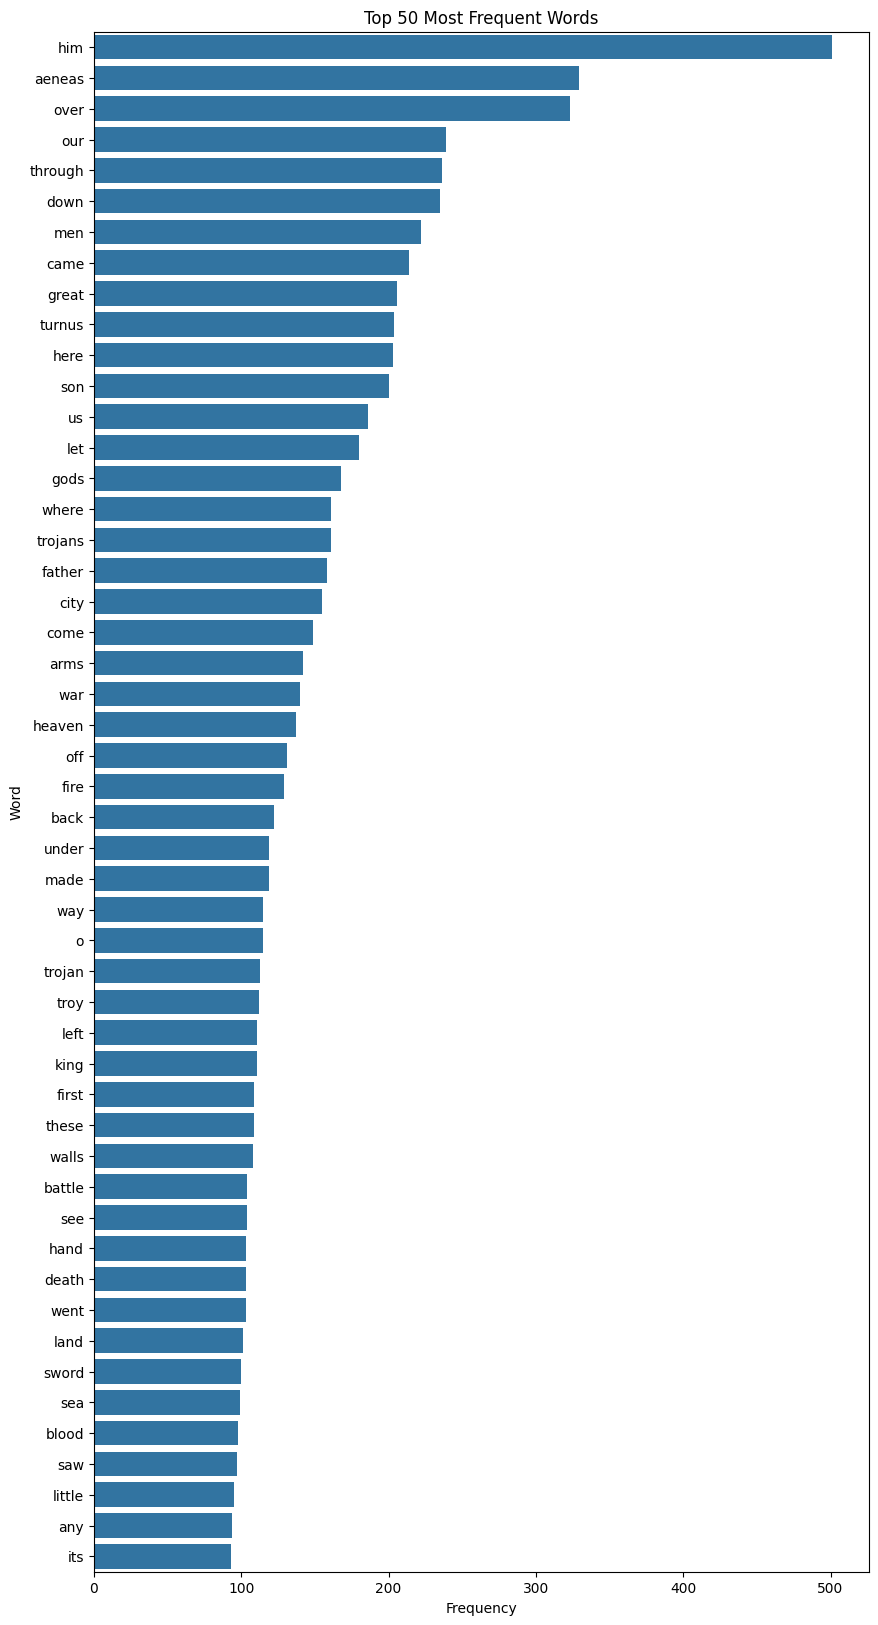

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a bar plot using seaborn
plt.figure(figsize=(10, 20))  # Adjust width and height as needed
sns.barplot(x='count', y='word', data=top_n_df, orient='h')
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## Task 1: Longest Single Words

In [ ]:
# Task: Find the longest single word
def find_longest_single_word(rdd):
    # Flatten, map each word to (word, length), then find the longest word
    word_lengths = rdd.flatMap(split_line).map(lambda word: (word, len(word)))
    longest_word = word_lengths.takeOrdered(1, key=lambda x: -x[1])[0]
    return longest_word

# Execution for Task
longest_word, length = find_longest_single_word(text_file)

# Display result
print("Longest Single Word:")
print(f"{longest_word}: {length}")

Longest Single Word:
invulnerability: 15


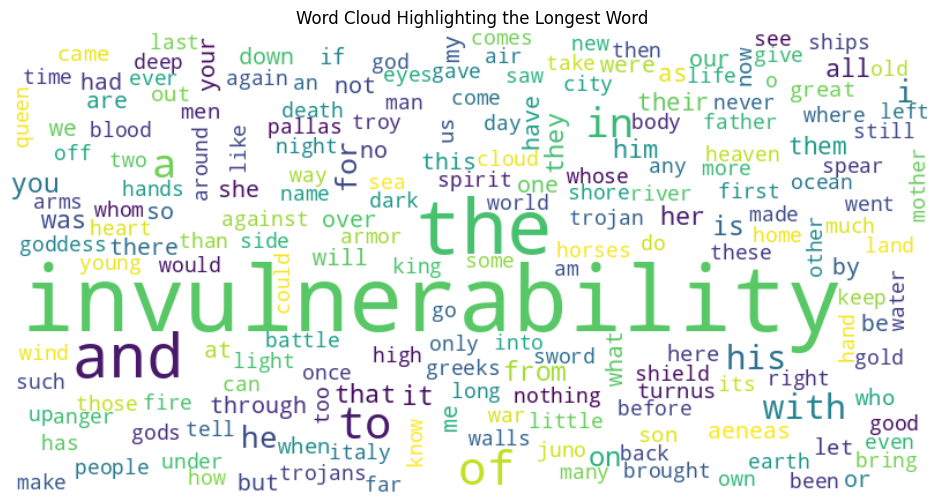

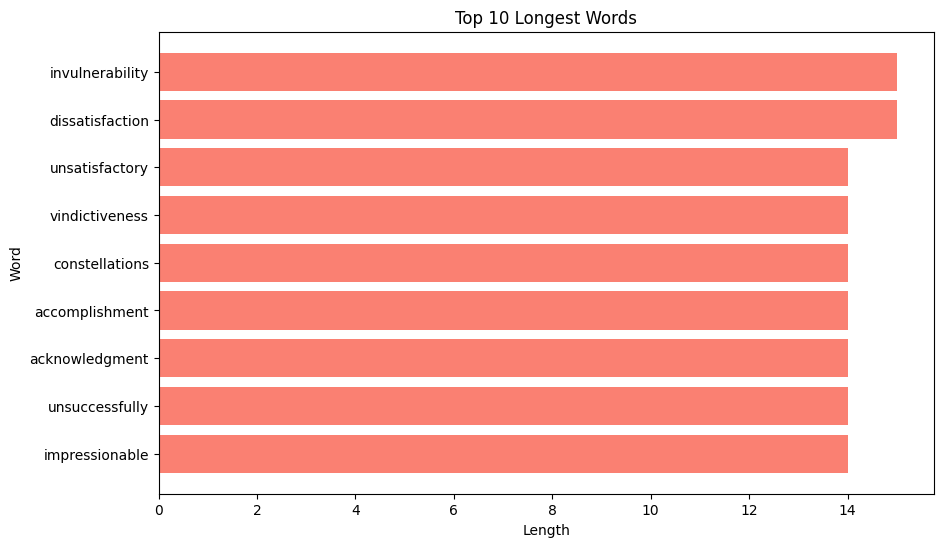

In [ ]:
from wordcloud import WordCloud

# Generate word cloud data using the longest word
# Assuming `text_file` is the cleaned RDD of words
frequent_words = text_file.flatMap(split_line).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).collect()
word_freq_dict = dict(frequent_words)

# Set a high frequency for the longest word to emphasize it
word_freq_dict[longest_word] = max(word_freq_dict.values()) * 1.5  # Boost its frequency for emphasis

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Highlighting the Longest Word')
plt.show()

# Adjust the find_longest_single_word function to return the top N longest words
def find_top_longest_words(rdd, top_n=10):
    word_lengths = rdd.flatMap(split_line).map(lambda word: (word, len(word)))
    longest_words = word_lengths.takeOrdered(top_n, key=lambda x: -x[1])
    return longest_words

# Execution for top 10 longest words
top_longest_words = find_top_longest_words(text_file, top_n=10)

# Extract words and their lengths for plotting
words = [word for word, length in top_longest_words]
lengths = [length for word, length in top_longest_words]

# Plot the longest words
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(words, lengths, color='salmon')
plt.xlabel('Length')
plt.ylabel('Word')
plt.title('Top 10 Longest Words')
plt.gca().invert_yaxis()  # Longest word at the top
plt.show()


## Task 2: Most Frequent Bigrams

In [ ]:
# Split into words
words_list = cleaned_text.split()

# Create an RDD from the list of words
words_rdd = sc.parallelize(words_list)


# Task: Find the most frequent bigrams
def find_most_frequent_bigrams(rdd, top_n=10):
    # Filter words
    filtered_words = rdd.filter(filter_word)

    # Create (index, word) pairs
    indexed_words = filtered_words.zipWithIndex().map(lambda x: (x[1], x[0]))

    # Create (index, word) shifted by one to get next word
    shifted_words = indexed_words.map(lambda x: (x[0] - 1, x[1]))

    # Join on index to get bigrams
    bigrams_rdd = indexed_words.join(shifted_words).filter(lambda x: x[0] >= 0)

    # Map bigrams to ('word1 word2', 1)
    bigrams = bigrams_rdd.map(lambda x: (' '.join(x[1]), 1))

    # Count bigrams
    bigram_counts = bigrams.reduceByKey(lambda a, b: a + b)

    # Get top N bigrams
    most_common_bigrams = bigram_counts.takeOrdered(top_n, key=lambda x: -x[1])
    return most_common_bigrams

# Execution for Task
top_bigrams = find_most_frequent_bigrams(words_rdd, top_n=10)

# Display result
print("Most Frequent Bigrams:")
for bigram, frequency in top_bigrams:
    print(f"{bigram}: {frequency}")

Most Frequent Bigrams:
let him: 32
far off: 29
let us: 25
three times: 23
king latinus: 18
right hand: 17
over sea: 17
young men: 17
over over: 16
came down: 14


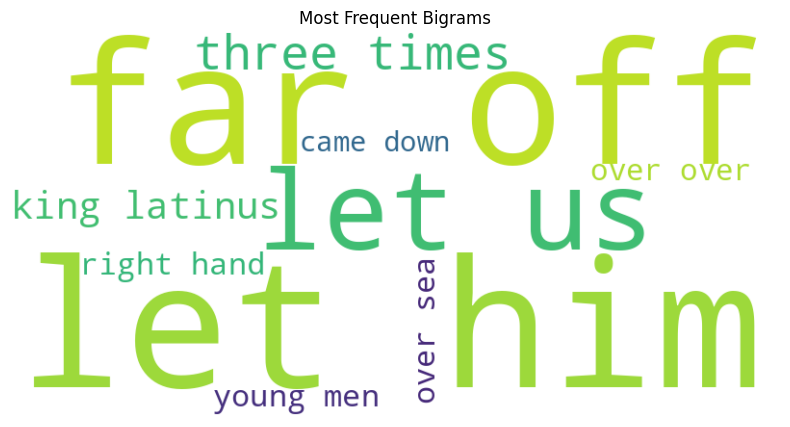

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sample data from the previous task's output
top_bigrams = find_most_frequent_bigrams(words_rdd, top_n=10)

# Extract bigrams and their frequencies
bigrams = [bigram for bigram, _ in top_bigrams]
frequencies = [frequency for _, frequency in top_bigrams]


# Generate a word cloud from the bigrams and frequencies
bigram_dict = {bigram: frequency for bigram, frequency in top_bigrams}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Bigrams')
plt.show()


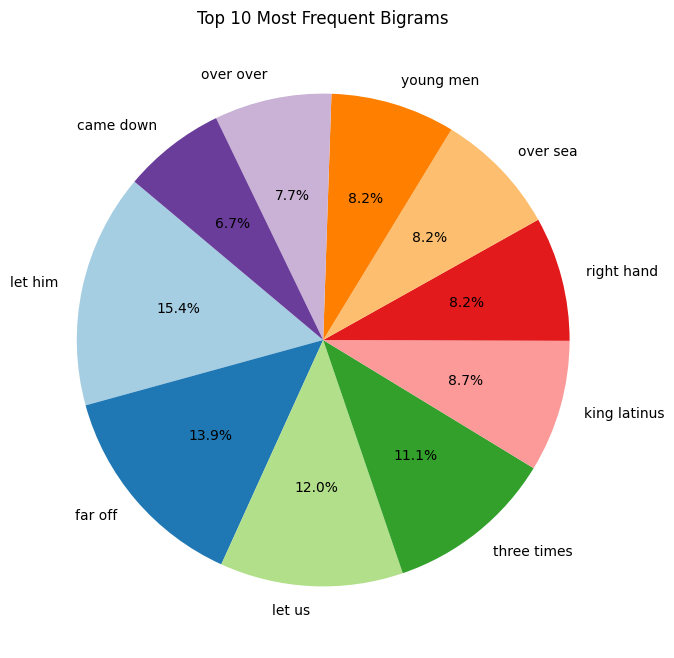

In [ ]:


plt.figure(figsize=(8, 8))
plt.pie(frequencies, labels=bigrams, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Most Frequent Bigrams')
plt.show()


## Task 3: Customized Statistic

## Analysis of most sofisticated sentences based on average word length of each delineated sentence.
### Task Description
* **Extract Sentences:** Split the text by sentence boundaries.
* **Tokenize Words in Each Sentence:** For each sentence, split it into words.
* **Calculate Word Lengths:** Compute the length of each word.
* **Calculate Average Word Length per Sentence:** For each sentence, compute the average word length by dividing the total character count by the number of words.
* **Aggregate and Display Results:** Display the results and provide overall statistics, such as the longest and shortest average word length in sentences.





In [ ]:
# Clean the text and split by sentence boundaries (naïve approach using ".", "!", "?")
sentences = re.split(r'[.!?]', text.lower())

# Create an RDD from the list of sentences
sentences_rdd = sc.parallelize(sentences)

# Helper function to split a sentence into words and filter out non-alphabetic characters
def split_words(sentence):
    # Remove non-alphabetic characters and split into words
    words = re.findall(r'\b[a-z]+\b', sentence)
    return words

# Task: Calculate average word length by sentence
def average_word_length_by_sentence(rdd):
    # For each sentence, split into words and calculate word lengths
    sentence_word_lengths = rdd.map(lambda sentence: split_words(sentence)) \
                               .filter(lambda words: len(words) > 0) \
                               .map(lambda words: (sum(len(word) for word in words), len(words)))

    # Calculate average word length for each sentence
    sentence_avg_lengths = sentence_word_lengths.map(lambda x: x[0] / x[1])

    # Collect results
    avg_lengths = sentence_avg_lengths.collect()

    # Calculate and print statistics
    overall_avg_length = sum(avg_lengths) / len(avg_lengths)
    longest_avg_length = max(avg_lengths)
    shortest_avg_length = min(avg_lengths)

    print(f"Overall Average Word Length per Sentence: {overall_avg_length:.2f}")
    print(f"Longest Average Word Length in a Sentence: {longest_avg_length:.2f}")
    print(f"Shortest Average Word Length in a Sentence: {shortest_avg_length:.2f}")

    # Return the list of average lengths if further analysis is needed
    return avg_lengths

# Execution for Task
average_lengths = average_word_length_by_sentence(sentences_rdd)

Overall Average Word Length per Sentence: 4.27
Longest Average Word Length in a Sentence: 8.00
Shortest Average Word Length in a Sentence: 1.00




* **Map Each Sentence to Words and Calculate Lengths:** Each sentence is split into words, and the total character length and word count are calculated.
* **Calculate Average Word Length**: For each sentence, we calculate the average word length by dividing the total character count by the word count.
* **Retrieve *Top N* Sentences:** We sort sentences by their average word length in descending order and take the top N.
* **Print Results:** Each top sentence with its average word length is printed.

In [ ]:

# Clean the text and split by sentence boundaries (using ".", "!", "?")
sentences = re.split(r'[.!?]', text.lower())

# Create an RDD from the list of sentences
sentences_rdd = sc.parallelize(sentences)

# Helper function to split a sentence into words and filter out non-alphabetic characters
def split_words(sentence):
    # Remove non-alphabetic characters and split into words
    words = re.findall(r'\b[a-z]+\b', sentence)
    return words

# Task: Find 10 sentences with the longest average word length
def top_sentences_by_avg_word_length(rdd, top_n=10):
    # For each sentence, split into words and calculate word lengths
    sentence_word_lengths = rdd.map(lambda sentence: (sentence, split_words(sentence))) \
                               .filter(lambda x: len(x[1]) > 0) \
                               .map(lambda x: (x[0], sum(len(word) for word in x[1]), len(x[1])))

    # Calculate average word length for each sentence
    sentence_avg_lengths = sentence_word_lengths.map(lambda x: (x[0], x[1] / x[2]))

    # Get the top N sentences with the longest average word length
    top_sentences = sentence_avg_lengths.takeOrdered(top_n, key=lambda x: -x[1])

    # Display results
    print(f"Top {top_n} Sentences with Longest Average Word Length:")
    for sentence, avg_length in top_sentences:
        print(f"AWL: {avg_length:.2f} | Sentence: {sentence.strip()}")

    return top_sentences

# Execution for Task
top_sentences = top_sentences_by_avg_word_length(sentences_rdd, top_n=10)

Top 10 Sentences with Longest Average Word Length:
AWL: 8.00 | Sentence: euryalus, euryalus
AWL: 7.17 | Sentence: should aeneas travel
    through danger, unendangered
AWL: 7.00 | Sentence: how meaningless
AWL: 7.00 | Sentence: nothing
AWL: 6.75 | Sentence: philoctetes
    commands her walls
AWL: 6.67 | Sentence: inflict the punishment
AWL: 6.67 | Sentence: what harrying punishment, what horrible outcry
AWL: 6.67 | Sentence: choose foreign leaders
AWL: 6.60 | Sentence: --he sharpens
    slander with apprehension
AWL: 6.50 | Sentence: fortunate boys


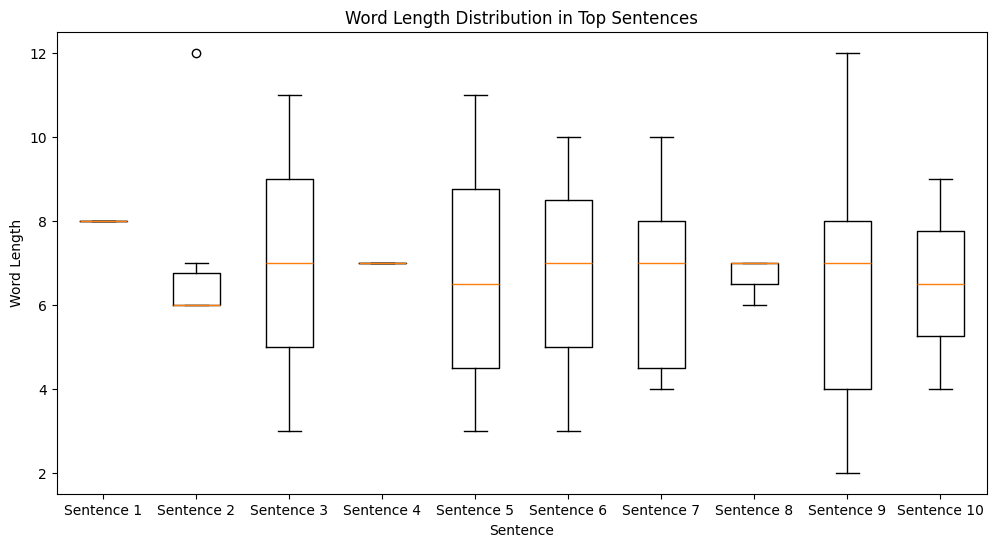

In [ ]:
word_lengths_per_sentence = []

for sentence, avg_length in top_sentences:
    words = split_words(sentence)
    word_lengths = [len(word) for word in words]
    word_lengths_per_sentence.append(word_lengths)

plt.figure(figsize=(12, 6))
plt.boxplot(word_lengths_per_sentence, labels=[f"Sentence {i+1}" for i in range(len(top_sentences))])
plt.title('Word Length Distribution in Top Sentences')
plt.xlabel('Sentence')
plt.ylabel('Word Length')
plt.show()


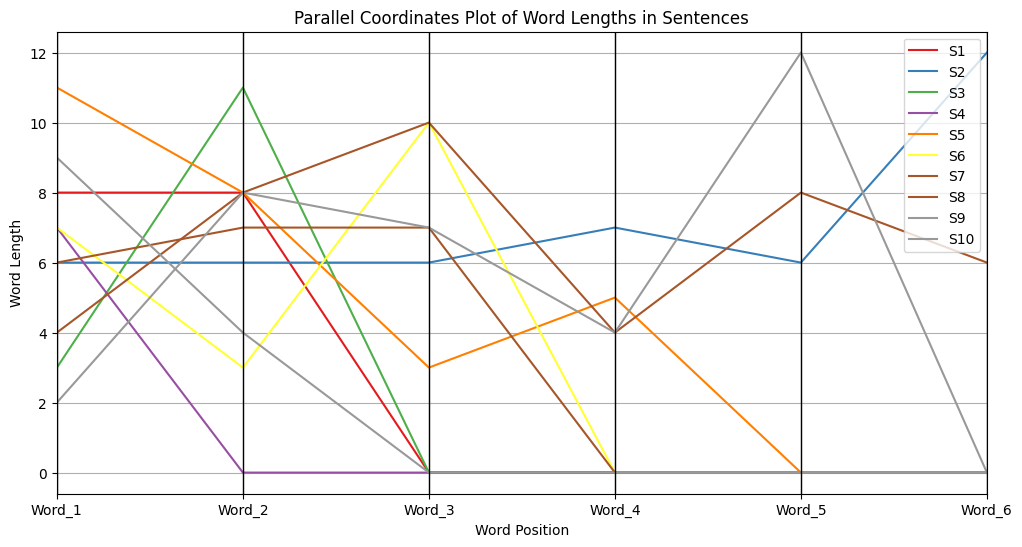

In [ ]:
import pandas as pd
from pandas.plotting import parallel_coordinates

# Prepare data
data = []
for idx, (sentence, _) in enumerate(top_sentences):
    words = split_words(sentence)
    word_lengths = [len(word) for word in words]
    # Create a dictionary for each sentence
    sentence_dict = {'Sentence': f"S{idx+1}"}
    for i, length in enumerate(word_lengths):
        sentence_dict[f'Word_{i+1}'] = length
    data.append(sentence_dict)

# Convert to DataFrame
df = pd.DataFrame(data)
df = df.fillna(0)  # Fill missing values with zero

# Plot parallel coordinates
plt.figure(figsize=(12, 6))
parallel_coordinates(df, 'Sentence', colormap='Set1')
plt.title('Parallel Coordinates Plot of Word Lengths in Sentences')
plt.xlabel('Word Position')
plt.ylabel('Word Length')
plt.legend(loc='upper right')
plt.show()
